## Language Traslation with RNNs


In [1]:
#import all the necessary libraries here

import pandas as pd
import numpy as np
import os
import collections
import random
import string
from aitk.networks import Network
from sklearn.model_selection import train_test_split
from read_data import read_data, read_tsv_data, to_vocab, trim_vocab, shuffle_data #helper function 
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from keras.layers import GRU, Dense, TimeDistributed, Input, Embedding, Dropout, SimpleRNN, Bidirectional, RepeatVector # import layers we'll need
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.losses import sparse_categorical_crossentropy
from keras.layers import LSTM
from nltk.translate.bleu_score import sentence_bleu

2023-12-20 20:16:04.798900: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#define any globa variables here:
learning_rate = 0.001
adam = Adam(learning_rate)
rms = RMSprop(learning_rate)
EMBEDDING_DIM = 200 #can only be 50, 100, 200, and 300 to match the glove dimensions

### Part 1: Data Processing

In [33]:
# load the data
english_dataset_small = read_data("/scratch/CS66_Resource/data/small_vocab_en")
french_dataset_small = read_data("/scratch/CS66_Resource/data/small_vocab_fr")
eng_fr_tsv = "/scratch/CS66_Resource/data/fra.txt"

#read the tsv data
english, french = read_tsv_data(eng_fr_tsv)
#down sample the big dataset

eng_vocab  = to_vocab(english) # counter 
english_dataset_big, french_dataset_big = trim_vocab(english, french, eng_vocab, 500000)


english_dataset_big.extend(english_dataset_small)
french_dataset_big.extend(french_dataset_small)

#shuffle the data after extending it

english_dataset_big, french_dataset_big = shuffle_data(english_dataset_big, french_dataset_big)


In [4]:
#xplore the data
def explore_dataset(language_dataset,lang_dataset_name, translate_dataset, trans_dataset_name):
    lang_words_counter = collections.Counter([word for sentence in language_dataset for word in sentence.split()])
    trans_words_counter = collections.Counter([word for sentence in translate_dataset for word in sentence.split()])

    print(f'{lang_dataset_name} words {(len([word for sentence in language_dataset for word in sentence.split()]))}')
    print(f'unique {lang_dataset_name} words: {(len(lang_words_counter))}')
    print(f'10 Most common words in the {lang_dataset_name} dataset:')
    print('"' + '" "'.join(list(zip(*lang_words_counter.most_common(10)))[0]) + '"')
    print()
    print(f'{trans_dataset_name} words {(len([word for sentence in translate_dataset for word in sentence.split()]))}')
    print(f'unique {trans_dataset_name} words: {(len(trans_words_counter))}')
    print(f'10 Most common words in the {trans_dataset_name} dataset:')
    print('"' + '" "'.join(list(zip(*trans_words_counter.most_common(10)))[0]) + '"')

# explore_dataset(english_dataset,"English", french_dataset, "French")
print("-"*100)
print()

# explore_dataset(eng_train,"English", fra_train, "Fra")
explore_dataset(english_dataset_big,"English", french_dataset_big, "French")
# explore_dataset(deu_train,"Deu", eng_train, "Eng")
print(english_dataset_big[120:125])
print(french_dataset_big[120:125])



----------------------------------------------------------------------------------------------------

English words 2250851
unique English words: 13682
10 Most common words in the English dataset:
"is" "the" "it" "in" "during" "but" "and" "never" "sometimes" "usually"

French words 2439009
unique French words: 24459
10 Most common words in the French dataset:
"est" "en" "il" "les" "mais" "la" "et" "le" "jamais" "de"
['did you read them', 'california is busy during autumn  and it is hot in february ', 'the united states is usually quiet during spring  but it is usually warm in march ', 'his favorite fruit is the grapefruit  but our favorite is the grape', 'new jersey is sometimes rainy during may  and it is usually snowy in august ']
['les astu lus ', 'californie est occupe au cours de l automne  et il est chaud en fevrier ', 'les etatsunis est generalement calme au printemps  mais il est habituellement chaud en mars ', 'son fruit prefere est le pamplemousse  mais notre prefere est le c

In [5]:
#Tokenize and Pad the data

def tokenize(data):
    """given a dataset, return a tokenized dataset"""
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    return tokenizer.texts_to_sequences(data), tokenizer

In [6]:
# test  tokenizer
tokenized_sents, tokenizer = tokenize(english_dataset_big[:5])
for idx, (input_sent, output_sent) in enumerate(zip(english_dataset_big[:5], tokenized_sents)):
    print(f"input sentence: {input_sent}")
    print(f"tokenized sentence: {output_sent}")
    

input sentence: he continued to mock me
tokenized sentence: [1, 6, 2, 7, 8]
input sentence: new jersey is never cold during may  and it is sometimes busy in march 
tokenized sentence: [9, 10, 3, 11, 12, 13, 14, 4, 15, 3, 16, 17, 18, 19]
input sentence: why did she go to china 
tokenized sentence: [20, 21, 22, 23, 2, 24]
input sentence: he dislikes mangoes  oranges  and apples 
tokenized sentence: [1, 25, 26, 27, 4, 28]
input sentence: the driver of the bus was injured
tokenized sentence: [5, 29, 30, 5, 31, 32, 33]


In [7]:
#padd the data
def pad_data(tokenized_data, max_len=None):
    """ Given a tokenized dataset, add padding to it.
    This ensures that all the tokenes are of the same length"""
    return pad_sequences(tokenized_data, maxlen = max_len, padding= 'post')

In [8]:
#test padding:
padded_sentences = pad_data(tokenized_sents)
for input_token, output_token in zip(tokenized_sents, padded_sentences):
    print(f'input token: {input_token}, len: {len(input_token)}')
    print(f'padded_token: {output_token}, len: {len(output_token)}')

input token: [1, 6, 2, 7, 8], len: 5
padded_token: [1 6 2 7 8 0 0 0 0 0 0 0 0 0], len: 14
input token: [9, 10, 3, 11, 12, 13, 14, 4, 15, 3, 16, 17, 18, 19], len: 14
padded_token: [ 9 10  3 11 12 13 14  4 15  3 16 17 18 19], len: 14
input token: [20, 21, 22, 23, 2, 24], len: 6
padded_token: [20 21 22 23  2 24  0  0  0  0  0  0  0  0], len: 14
input token: [1, 25, 26, 27, 4, 28], len: 6
padded_token: [ 1 25 26 27  4 28  0  0  0  0  0  0  0  0], len: 14
input token: [5, 29, 30, 5, 31, 32, 33], len: 7
padded_token: [ 5 29 30  5 31 32 33  0  0  0  0  0  0  0], len: 14


In [9]:
def split_data(X, y, split_ratio = 0.40):
    """This functions splits the input dataset into train and test split

    Args:
        X (_type_): Main Language dataset
        y (_type_): Translated Language dataset
        split_ratio (float, optional): Train and Test split ratio. Defaults to 0.40.
    """
    
    train_size = int((len(X)* (1-split_ratio)))
    
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    

In [10]:
#full preprocessing
def pre_processing(x, y):
    """
    Take in a dataset(list of sentences), tokenize the data, and pad it
    """
    x_tokenized_sentences, x_tk = tokenize(x) 
    y_tokenized_sentences, y_tk = tokenize(y) 
    max_len_x = max(len(seq) for seq in x_tokenized_sentences)
    max_len_y = max(len(seq) for seq in y_tokenized_sentences)
    max_len_global = max(max_len_x, max_len_y)
    y_pad_sentences  = pad_data(y_tokenized_sentences, max_len_global)
    x_pad_sentences  = pad_data(x_tokenized_sentences, max_len_global) 

    
    return x_pad_sentences , y_pad_sentences, x_tk, y_tk

In [11]:
#Pre process datasets before using them and split

eng, fr , eng_tk, fr_tk = pre_processing(english_dataset_big, french_dataset_big)

eng_train_x, eng_test_x, fr_train_y, fr_test_y = split_data(eng, fr)


#### Convert a output to actual sentences
- The predictions of the model are going to be token IDs that we created when tokenizing the data. 
- We can rely on the tokenizer that we used to tokenize the words to convert the token IDs to the words they stand for




In [12]:
def logits_to_words(tokenizer, logits):
    """Function to convert tokens back to words based on the tokenizer that generated 
    the words
    Args:
        tokenizer (Tokenizer): The tokenizer that was used to convert the words
        logits(List): A list of tokens that we want to convert back to words to
        make a sentence. 
    """ 
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'  
        
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


In [13]:
def plot_validation_and_accuracy_curve(history):
    """
    Function that takes in a histroy object from the trained models and plot validation and accuracy
    Args:
        history: The metrics(accuracy and loss) used to plot the curves
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot for accuracy
    axes[0].plot(history.history['accuracy'], label='accuracy')
    axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='upper left')

    # Plot for loss
    axes[1].plot(history.history['loss'], label='loss')
    axes[1].plot(history.history['val_loss'], label='val_loss')
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper left')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Save the figure
    plt.savefig('accuracy_loss_plot.png')

    # Show the plots
    plt.show()

### Part 2: Building the Models

In [14]:
#build simple model, with an embedding trained from scratch

def simple_rnn(input_shape, x_vocab_size,  y_vocab_size):
    """
    Build and train a simple RNN on x and y
    :param input_shape: Tuple of input shape
    :param x_vocab_size: Number of unique words in the x language dataset
    :param y_vocab_size: Number of unique words in the y language dataset
    
    :return: Keras model built, but not trained
    """    
    
    #Build the model
    model = Sequential()
    model.add(Embedding(x_vocab_size, EMBEDDING_DIM, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(SimpleRNN(512, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(y_vocab_size, activation='softmax')))

    # Compile the model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model

In [15]:
#build GRU model, with an embedding trained from scratch

def gru_rnn(input_shape, x_vocab_size,  y_vocab_size):
    """
    Build and train a GRU RNN on x and y
    :param input_shape: Tuple of input shape
    :param x_vocab_size: Number of unique words in the x language dataset
    :param y_vocab_size: Number of unique words in the y language dataset
    :return: Keras model built, but not trained
    """    
    
    #Build the model
    model = Sequential()
    model.add(Embedding(x_vocab_size, EMBEDDING_DIM, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(y_vocab_size, activation='softmax')))

    # Compile the model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model

In the next part, we'll be incorporating pretrained embedding from glove in our. Before we do that, let's define a few util functions that help us with reading the glove embedding weights. https://nlp.stanford.edu/projects/glove/

In [17]:
#implement an LSTM model with the Keras embedding

def lstm_model(input_shape, x_vocab_size, y_vocab_size):
    """
    Build and train an LSTM RNN model on x and y
    :param input_shape: Tuple of input shape
    :param x_vocab_size: Number of unique words in the x language dataset
    :param y_vocab_size: Number of unique words in the y language dataset
    :return: Keras model built, but not trained
    """ 

    # Build the model
    model = Sequential()
    model.add(Embedding(x_vocab_size, EMBEDDING_DIM, input_length=input_shape[1]))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(216, return_sequences=True))
    # model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.7))
    model.add(TimeDistributed(Dense(y_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [18]:
#try to predict and see what happens
def evaluate_model(model, X, y, X_tk, y_tk, num_samples=5):
    """
    Function that takes in a histroy object from the trained models and plot validation and accuracy
    Args:
        model: The metrics(accuracy and loss) used to plot the curves
        X: input data used for making predictions.
        y: actual target data corresponding to the input data
        X_tk: the token to word mapping for the input data
        y_tk: the token to word mapping for the target data
        num_samples: the number of samples from the input data that the we will process and valuate
    """
    #process the data: 
    for i in range(num_samples):
        index = np.random.randint(0, len(X))
        input_sequence = X[index : index + 1]
        predicted_logits = model.predict(input_sequence)[0]
        #print("prediction:", predicted_logits)
        predicted_sequence = logits_to_words(y_tk,predicted_logits)
        

        input_text = " ".join([X_tk.index_word[idx] for idx in input_sequence[0] if idx != 0])
        target_text = " ".join([y_tk.index_word[idx] for idx in y[index] if idx != 0])
        # predicted_text = " ".join(predicted_sequence)
        print(f"Input:      {input_text}")
        print(f"Target:     {target_text}")
        print(f"Predicted : {predicted_sequence}\n")
       
        print("-"*len(predicted_sequence))






In [19]:
#train the model
def train_model(model, X_train, y_train, X_test, y_test, X_tk, y_tk, epochs = 20):
    """A function that generalizes the training process for our models to gauge accuracy

    Args:
        model (string): the model to train
        X (array): An array with the input untokenized data
        y (array): An array with the target untokenized data
        X_test (array): Input data for testing the model
        y_test (array): Target data corresponding to X_test
        X_tk: the token to word mapping for the input data
        y_tk: the token to word mapping for the target data
        epochs: Numberof training iterations to peform, equal to 20

        
    Return:
         model: the trained model for evaluation using testing data
    """
    #first procxess the data 
    try:
        assert len( X_train) == len(y_train)
    except AssertionError: 
        print("Input and target data have different sizes. Might be missing some data!")
    
    
    try:
        assert X_train.shape == y_train.shape
    except AssertionError: 
        print("Input and target data have different Dimensions!")
        return 
     
    print(X_train.shape, y_train.shape) 
    if model == "basic":
        print(f"training the {model} model ...")
        basic_rnn = simple_rnn(X_train.shape, len(X_tk.word_index)+1, len(y_tk.word_index)+1)
        history = basic_rnn.fit(X_train, y_train, epochs=epochs, validation_split = 0.4 )
        plot_validation_and_accuracy_curve(history)
        score = basic_rnn.evaluate(X_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return basic_rnn
    
    elif model == "gru":
        print(f"Selected the {model}")
                            
        gru_model = gru_rnn(X_train.shape, len(X_tk.word_index)+1, len(y_tk.word_index)+1)
        history = gru_model.fit(X_train, y_train, epochs=epochs, validation_split = 0.4 )
        plot_validation_and_accuracy_curve(history)
        score = gru_model.evaluate(X_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return gru_model
        
    elif model == "lstm": 
        print(f"Selected the {model}")
        #get the lstm model 
        lstm = lstm_model(X_train.shape, len(X_tk.word_index)+1, len(y_tk.word_index)+1)
        history = lstm.fit(X_train, y_train, epochs=epochs, validation_split = 0.4 )
        plot_validation_and_accuracy_curve(history)
        score = lstm.evaluate(X_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return lstm
    else:
        print("The only available models are: ", ["basic","gru", "lstm"])

English-French DataSet

(151656, 51) (151656, 51)
training the basic model ...


2023-12-20 20:16:25.220820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-20 20:16:25.228900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-20 20:16:25.228995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-20 20:16:25.229505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Epoch 1/30


2023-12-20 20:16:26.859314: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2844/2844 [==============================] - 381s 133ms/step - loss: 0.7447 - accuracy: 0.8763 - val_loss: 0.4794 - val_accuracy: 0.9140
Epoch 2/30
2844/2844 [==============================] - 381s 134ms/step - loss: 0.4325 - accuracy: 0.9197 - val_loss: 0.4134 - val_accuracy: 0.9243
Epoch 3/30
2844/2844 [==============================] - 380s 134ms/step - loss: 0.3839 - accuracy: 0.9258 - val_loss: 0.3952 - val_accuracy: 0.9279
Epoch 4/30
2844/2844 [==============================] - 375s 132ms/step - loss: 0.3557 - accuracy: 0.9290 - val_loss: 0.3884 - val_accuracy: 0.9290
Epoch 5/30
2844/2844 [==============================] - 374s 131ms/step - loss: 0.3360 - accuracy: 0.9310 - val_loss: 0.3787 - val_accuracy: 0.9314
Epoch 6/30
2844/2844 [==============================] - 372s 131ms/step - loss: 0.3209 - accuracy: 0.9327 - val_loss: 0.3831 - val_accuracy: 0.9313
Epoch 7/30
2844/2844 [==============================] - 371s 131ms/step - loss: 0.3102 - accuracy: 0.9338 - val_loss: 0.372

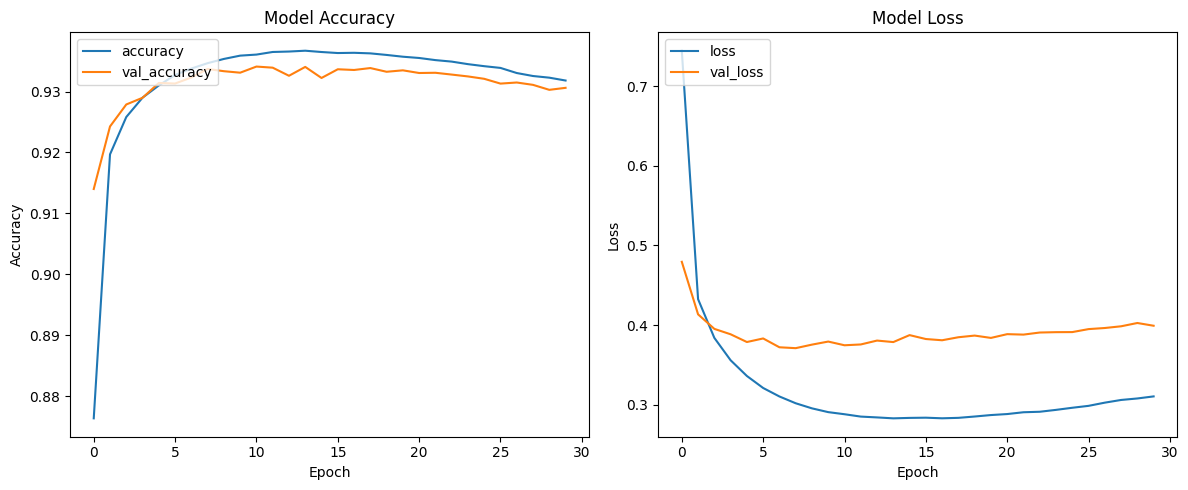

Test loss: 0.4002397358417511
Test accuracy: 0.9307960867881775
1/1 [==============================] - 0s 110ms/step
Input:      california is never wet during august and it is quiet in july
Target:     californie est jamais humide au mois d aout et il est calme en juillet
Predicted : californie est jamais humide en mois d aout et il est calme en juillet <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
Input:      new jersey is usually busy during november and it is sometimes 

In [20]:
print("English-French DataSet")
print()

basic_model = train_model("basic", eng_train_x, fr_train_y ,eng_test_x ,fr_test_y, eng_tk,  fr_tk, 30)

evaluate_model(basic_model ,eng_test_x ,fr_test_y, eng_tk,  fr_tk, num_samples=10)

(151656, 51) (151656, 51)
Selected the gru
Epoch 1/30


2023-12-20 23:24:31.151248: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


2844/2844 [==============================] - 340s 119ms/step - loss: 0.6357 - accuracy: 0.8908 - val_loss: 0.4291 - val_accuracy: 0.9195
Epoch 2/30
2844/2844 [==============================] - 336s 118ms/step - loss: 0.3988 - accuracy: 0.9227 - val_loss: 0.3716 - val_accuracy: 0.9288
Epoch 3/30
2844/2844 [==============================] - 334s 117ms/step - loss: 0.3439 - accuracy: 0.9304 - val_loss: 0.3436 - val_accuracy: 0.9336
Epoch 4/30
2844/2844 [==============================] - 331s 116ms/step - loss: 0.3099 - accuracy: 0.9348 - val_loss: 0.3324 - val_accuracy: 0.9358
Epoch 5/30
2844/2844 [==============================] - 329s 116ms/step - loss: 0.2860 - accuracy: 0.9376 - val_loss: 0.3240 - val_accuracy: 0.9375
Epoch 6/30
2844/2844 [==============================] - 329s 116ms/step - loss: 0.2675 - accuracy: 0.9396 - val_loss: 0.3176 - val_accuracy: 0.9388
Epoch 7/30
2844/2844 [==============================] - 327s 115ms/step - loss: 0.2531 - accuracy: 0.9412 - val_loss: 0.321

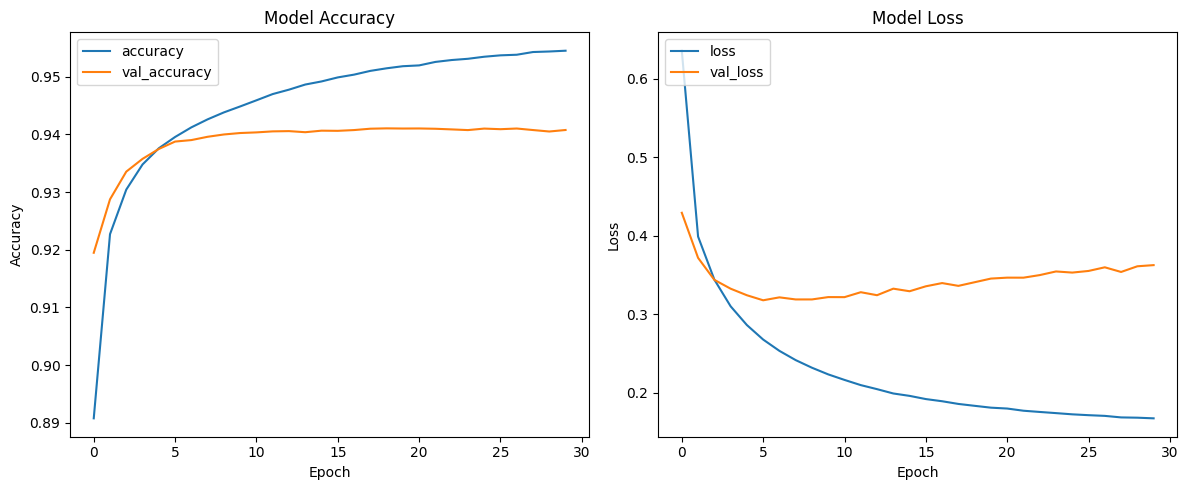

Test loss: 0.3631923198699951
Test accuracy: 0.9406945705413818
1/1 [==============================] - 0s 200ms/step
Input:      im not sure about anything
Target:     je ne suis sur de rien
Predicted : je ne suis pas de <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
Input:      france is usually busy during july and it is sometimes rainy in autumn
Target:     la france est generalement occupe en juillet et il est parfoi

In [21]:
gru_model = train_model("gru", eng_train_x, fr_train_y ,eng_test_x ,fr_test_y, eng_tk,  fr_tk, 30)

evaluate_model(gru_model ,eng_test_x ,fr_test_y, eng_tk,  fr_tk, num_samples=10)

(151656, 51) (151656, 51)
Selected the lstm
Epoch 1/30
2844/2844 [==============================] - 234s 82ms/step - loss: 0.8773 - accuracy: 0.8534 - val_loss: 0.5823 - val_accuracy: 0.8876
Epoch 2/30
2844/2844 [==============================] - 233s 82ms/step - loss: 0.5496 - accuracy: 0.8972 - val_loss: 0.4598 - val_accuracy: 0.9147
Epoch 3/30
2844/2844 [==============================] - 232s 82ms/step - loss: 0.4595 - accuracy: 0.9152 - val_loss: 0.4057 - val_accuracy: 0.9269
Epoch 4/30
2844/2844 [==============================] - 232s 82ms/step - loss: 0.4121 - accuracy: 0.9247 - val_loss: 0.3830 - val_accuracy: 0.9310
Epoch 5/30
2844/2844 [==============================] - 232s 82ms/step - loss: 0.3826 - accuracy: 0.9295 - val_loss: 0.3679 - val_accuracy: 0.9333
Epoch 6/30
2844/2844 [==============================] - 232s 82ms/step - loss: 0.3627 - accuracy: 0.9326 - val_loss: 0.3542 - val_accuracy: 0.9360
Epoch 7/30
2844/2844 [==============================] - 232s 81ms/step - l

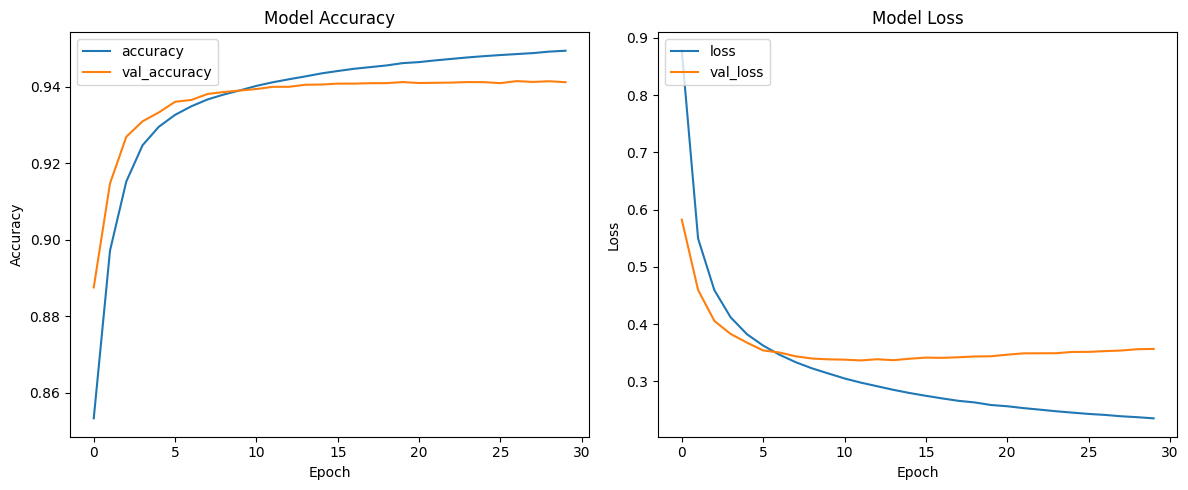

Test loss: 0.357965350151062
Test accuracy: 0.941152036190033
1/1 [==============================] - 0s 379ms/step
Input:      paris is hot during march and it is sometimes pleasant in june
Target:     paris est chaud en mars et il est parfois agreable en juin
Predicted : paris est chaud en mois et il est parfois agreable en juin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 12ms/step
Input:      france is quiet during may but it is beautiful in winter
Target:     la fran

In [23]:
lstm_model = train_model("lstm", eng_train_x, fr_train_y ,eng_test_x ,fr_test_y, eng_tk,  fr_tk, 30)

evaluate_model(lstm_model ,eng_test_x ,fr_test_y, eng_tk,  fr_tk, num_samples=10)


In [27]:
def GetPredictionSentenceWithoutPad(model, tokenizer, prediction_sent):
    """
    This function takes the model, its tokenizer and sentence to translate.
    It removes all paddings added to the predicted translated sentence and
    returns the translated sentence without pads.
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>' 
        
    pred =  [index_to_words[prediction] for prediction in np.argmax(model.predict(prediction_sent, verbose=0)[0], 1) if prediction != 0]
    return pred if len(pred) != 0 else None

    

In [29]:

def CalculateBleuStats(model, model_name, unprocessed_main_dataset, unprocessed_trans_dataset, trans_tk, main_test_dataset,fr_test_dataset ):
    """
    This function takes the test dataset and calculates the bleu score 
    """
    print("This is the Bleu Stat for ", model_name, " model.")
    _, _, _, bleu_refs = split_data(unprocessed_main_dataset, unprocessed_trans_dataset)

    
    references = [cand.lower().translate(str.maketrans('', '', string.punctuation)).split() for cand in bleu_refs]
    candidates = [GetPredictionSentenceWithoutPad(model, trans_tk, np.array([prediction_sent])) for prediction_sent in main_test_dataset]
    
    bleu_summation = 0
    full_cand = []
    full_ref = []
    
    # Loop removes all empty predictions from candidates and references list
    for idx,candidate in enumerate(candidates): 
        if candidate != None:
            full_cand.append(candidate)
            full_ref.append(references[idx])

    
    
    # Uses sentence bleu, this means references can be a list of list
    # but the candidate(can) has to be a list of token or words.
    # This function calculates the score for each sentence and prints the avg
    # It uses the candidate and reference list after popping empty predictions
    for idx, can in enumerate(full_cand):
        res = sentence_bleu([full_ref[idx]], can, weights = (1,0,0,0))
        bleu_summation += res
    print("The BLEU score is of model ", model_name, " is ", (bleu_summation/len(full_cand)))
    
    
    
print("------------------------------English-French DataSet-------------------------------------------------")
print()


CalculateBleuStats(basic_model, "basic rnn", english_dataset_big, french_dataset_big, fr_tk, eng_test_x, fr_test_y)
CalculateBleuStats(gru_model, "gru",english_dataset_big, french_dataset_big, fr_tk, eng_test_x, fr_test_y)
CalculateBleuStats(lstm_model, "lstm", english_dataset_big, french_dataset_big, fr_tk, eng_test_x, fr_test_y)
    

------------------------------English-French DataSet-------------------------------------------------

This is the Bleu Stat for  basic rnn  model.
101105 101105


/scratch/knerr/venvs/cs66/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/scratch/knerr/venvs/cs66/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/scratch/knerr/venvs/cs66/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

After popping: The total bleu score is 60614.63952200497  and the average score is  0.5996165707644251
This is the Bleu Stat for  gru  model.
101105 101105
After popping: The total bleu score is 67179.65592181055  and the average score is  0.664460910763279
This is the Bleu Stat for  lstm  model.
101105 101105
After popping: The total bleu score is 66969.67288089843  and the average score is  0.6624888501196822
